In [ ]:
pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 14.6 MB/s 


In [ ]:
### 1. Tahap Persiapan
#Import package/library yang diperlukan

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# untuk pre-processing teks
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
#untuk pembangunan model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_extraction.text  import CountVectorizer
# untuk word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
url = 'https://raw.githubusercontent.com/indolem/indolem/main/sentiment/data/train0.csv'
df = pd.read_csv(url, error_bad_lines=False)
df_train=df
url2 = 'https://raw.githubusercontent.com/indolem/indolem/main/sentiment/data/test0.csv'
df_test = pd.read_csv(url2, error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#pake preprocess aja

df_train
#df_test.head()

,sentence,sentiment
0,Kangen NaBil @RealSyahnazS @bangbily RaGa @Raf...,1
1,Doa utk orang yg mberi makan: Ya Allah! Berila...,1
2,"Setiap kali HP aku bunyi, aku selalu berharap ...",1
3,Belum pernah sedekat ini wawancara dgn Afgan S...,1
4,Dulu masa first pergi award show amatlah malas...,1
...,...,...
3633,linen nya terasa agak gatal... mungkin kurang ...,0
3634,Didaskaleinophobia adalah takut akan pergi ke ...,0
3635,Iklan partai Demokrat Katakan Tidak Pada Korup...,0
3636,Tempat tidurnya nyaman toilet kurang bersih,0


**B. Analisis Data Eksploratif**

Pada tahap eksplorasi data (Exploratory Data Analysis/EDA) ini, kita akan mencoba untuk 
melihat distribusi kelas, pengecekan missing data, penghitungan jumlah kata, karakter, dan visualisasi 
data

0    2567
1    1071
Name: sentiment, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


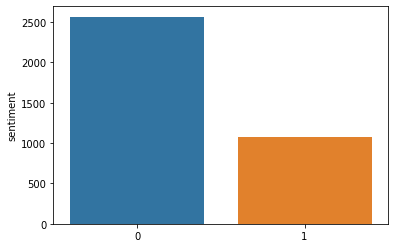

In [ ]:
#CLASS DISTRIBUTION
# mengecek apakah dataset yang digunakan balance atau tidak
x=df_train['sentiment'].value_counts()
print(x)
sns.barplot(x.index,x)

In [ ]:
#memeriksa missing value
df_train.isna().sum()

sentence     0
sentiment    0
dtype: int64

In [ ]:
#1. WORD-COUNT
df_train['word_count'] = df_train['sentence'].apply(lambda x:  len(str(x).split()))
print(df_train[df_train['sentiment']==1]['word_count'].mean()) #Positive
print(df_train[df_train['sentiment']==0]['word_count'].mean()) #Negative
#2. CHARACTER-COUNT
df_train['char_count'] = df_train['sentence'].apply(lambda x: len(str(x)))
print(df_train[df_train['sentiment']==1]['char_count'].mean()) #Positive
print(df_train[df_train['sentiment']==0]['char_count'].mean()) #Negative
#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['sentence'].apply(lambda x: 
len(set(str(x).split())))
print(df_train[df_train['sentiment']==1]['unique_word_count'].mean()) 
#Positive
print(df_train[df_train['sentiment']==0]['unique_word_count'].mean()) 
#Negative


16.985060690943044
16.684456564082588
121.1484593837535
111.01051811453058
16.166199813258636
15.502532138683287


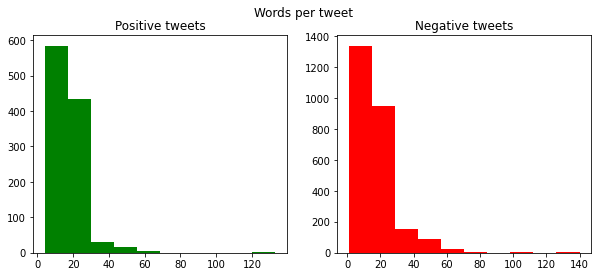

In [ ]:
# Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['sentiment']==1]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('Positive tweets')
train_words=df_train[df_train['sentiment']==0]['word_count']
ax2.hist(train_words,color='red')
ax2.set_title('Negative tweets')
fig.suptitle('Words per tweet')
plt.show()


**C. Teks Pre-processing**

Pada tahap ini, Anda akan melakukan beberapa teknik pre-processing teks sebelum melakukan 
pemodelan. Anda dapat menambahkan atau mengurangi tahapan pre-processing yang dirasa perlu 
berdasarkan sumber data teks yang digunakan.

In [ ]:
#1. Common text preprocessing
text = " This is a message to be cleaned. It may involve some things like: <br>, ?, :, '' adjacent spaces and tabs . "
# mengubah ke huruf kecil (lowercase) dan menghapus tanda baca, karakter aneh dan strip
def preprocess(text):
 text = text.lower() #lowercase text
 text=text.strip() #Menghapus leading/trailing whitespace
 text = re.sub('@[^\s]+','atUser',text) #mengubah @user menjadi atUser
 text = re.sub(r'#([^\s]+)', r'\1', text) #menghapus hashtag di depan suatu kata
 text=re.compile('<.*?>').sub('', text) #Menghapus HTML tags/markups
 text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) #Replace punctuation with space. Careful since punctuation can sometime be useful
 text = re.sub('\s+', ' ', text) #Menghapus extra space dan tabs
 text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
 text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
 text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
 text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace

 return text

#1. STOPWORD ELIMINATION
from spacy.lang.id import Indonesian
import spacy
def stopword_elim(text):
  nlp = Indonesian() # use directly
  nlp = spacy.blank('id') # blank instance'
  stopwords = nlp.Defaults.stop_words
  tokens = tokenisasi(text)
  tokens_nostopword = [w for w in tokens if not w in stopwords]
  return (" ").join(tokens_nostopword)
#2. STEMMING
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
def stemming(text):
  # create stemmer
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  # stemming process
  output = stemmer.stem(text)
  return output
def stemming_sentence(text):
  output = ""
  for token in tokenisasi(text):
    output = output + stemming(token) + " "
  return output[:-1]

# Tokenisasi kalimat
def tokenisasi(text):
    tokens = text.split(" ")
    return tokens




In [ ]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return preprocess(string)

In [ ]:
df_train['clean_text'] = df_train['sentence'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_test['clean_text'] = df_test['sentence'].apply(lambda x: finalpreprocess(x))
df_train.head()



,sentence,sentiment,clean_text
0,Kangen NaBil @RealSyahnazS @bangbily RaGa @Raf...,1,kangen nabil atuser atuser raga atuser atuser ...
1,Doa utk orang yg mberi makan: Ya Allah! Berila...,1,doa utk orang yg mberi makan ya allah berilah ...
2,"Setiap kali HP aku bunyi, aku selalu berharap ...",1,setiap kali hp aku bunyi aku selalu berharap i...
3,Belum pernah sedekat ini wawancara dgn Afgan S...,1,belum pernah sedekat ini wawancara dgn afgan s...
4,Dulu masa first pergi award show amatlah malas...,1,dulu masa first pergi award show amatlah malas...


**D. Ekstraksi Feature dari Data Teks**

Salah satu feature dari data teks yang dapat digunakan yaitu dalam bentuk vektor dari bag of word 
dengan menggunakan bobot TF.IDF. Gunakan kode di bawah ini untuk mendapatkan vektor TF.IDF 
dari sekumpulan input teks.


In [ ]:
X_train = df_train['clean_text']
y_train = df_train['sentiment']
X_test = df_test['clean_text']
y_test = df_test['sentiment']
# TF-IDF
# Konversi x_train ke vector karena model hanya dapat memproses angka, bukan  kata/karakter
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
# tfidf digunakan pada kalimat yang belum ditokenisasi, berbeda dengan word2vec
# Hanya men-transform x_test (bukan fit dan transform)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test) 
# Jangan melakukan fungsi fit() TfidfVectorizer ke data testing karena hal itu akan
# mengubah indeks kata & bobot sehingga sesuai dengan data testing. Sebaliknya, lakukan 
# fungsi fit pada data training, lalu gunakan hasil model pada data training tadi pada 
# data testing untuk menunjukkan fakta bahwa Anda menganalisis data testing hanya 
# berdasarkan apa yang dipelajari tanpa melihat data testing itu sendiri sebelumnya.

**E. Pembangunan Model Klasifikasi Teks dengan Naive Bayes**

Naive Bayes merupakan model klasifikasi probabilistik berdasarkan Teorema Bayes, yang 
menggunakan probabilitas untuk membuat prediksi berdasarkan pengetahuan sebelumnya tentang 
kondisi yang mungkin terkait. Algoritma ini paling cocok untuk kumpulan data besar karena 
mempertimbangkan setiap fitur secara independen, menghitung probabilitas setiap kategori, dan 
kemudian memprediksi kategori dengan probabilitas tertinggi

In [ ]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train) #model
#Melakukan prediksi nilai y pada dataset testing
y_predict_bayes = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]


**F. Evaluasi Model Klasifikasi**

Evaluasi dari model klasifikasi dapat dilakukan dengan kode berikut

In [ ]:
print(classification_report(y_test,y_predict_bayes))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_bayes))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       713
           1       0.80      0.39      0.52       298

    accuracy                           0.79      1011
   macro avg       0.80      0.67      0.69      1011
weighted avg       0.79      0.79      0.76      1011

Confusion Matrix: [[685  28]
 [183 115]]


Lanjutkan task klasifikasi teks pada modul 10 dengan menggunakan Rocchio Classification, k
Nearest Neighbor (kNN), dan Support Vector Machine (SVM).

**G. Pembangunan Model Klasifikasi Teks dengan Rocchio Classification**



In [ ]:
from sklearn.neighbors import NearestCentroid
rocchio_tfidf = NearestCentroid()
rocchio_tfidf.fit(X_train_vectors_tfidf, y_train) #model
#klasifikasi selalu ada data x dan y
#Melakukan prediksi nilai y pada dataset testing
y_predict_rocchio = rocchio_tfidf.predict(X_test_vectors_tfidf) 



In [ ]:
X_test_vectors_tfidf

<1011x9644 sparse matrix of type '<class 'numpy.float64'>'
	with 14566 stored elements in Compressed Sparse Row format>

In [ ]:
print(classification_report(y_test,y_predict_rocchio))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_rocchio))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70       713
           1       0.45      0.84      0.59       298

    accuracy                           0.66      1011
   macro avg       0.67      0.71      0.65      1011
weighted avg       0.76      0.66      0.67      1011

Confusion Matrix: [[414 299]
 [ 49 249]]


**H. Pembangunan Model Klasifikasi Teks dengan kNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors=5
knn_tfidf = KNeighborsClassifier(n_neighbors, weights='distance')
knn_tfidf.fit(X_train_vectors_tfidf, y_train) #model
#Melakukan prediksi nilai y pada dataset testing
y_predict_knn = knn_tfidf.predict(X_test_vectors_tfidf)


In [ ]:
print(classification_report(y_test,y_predict_knn))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_knn))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       713
           1       0.73      0.66      0.69       298

    accuracy                           0.83      1011
   macro avg       0.79      0.78      0.78      1011
weighted avg       0.82      0.83      0.82      1011

Confusion Matrix: [[639  74]
 [102 196]]


In [ ]:
X_train

0       kangen nabil atuser atuser raga atuser atuser ...
1       doa utk orang yg mberi makan ya allah berilah ...
2       setiap kali hp aku bunyi aku selalu berharap i...
3       belum pernah sedekat ini wawancara dgn afgan s...
4       dulu masa first pergi award show amatlah malas...
                              ...                        
3633    linen nya terasa agak gatal mungkin kurang ber...
3634    didaskaleinophobia adalah takut akan pergi ke ...
3635    iklan partai demokrat katakan tidak pada korup...
3636          tempat tidurnya nyaman toilet kurang bersih
3637    cari anggota baru geng motor sebar formulir ke...
Name: clean_text, Length: 3638, dtype: object

**I. Pembangunan Model Klasifikasi Teks dengan SVM**


In [ ]:
from sklearn import svm
svm_tfidf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm_tfidf.fit(X_train_vectors_tfidf, y_train) #model
#Melakukan prediksi nilai y pada dataset testing
y_predict_svm = svm_tfidf.predict(X_test_vectors_tfidf)


In [ ]:
print(classification_report(y_test,y_predict_svm))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_svm))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       713
           1       0.74      0.70      0.72       298

    accuracy                           0.84      1011
   macro avg       0.81      0.80      0.80      1011
weighted avg       0.84      0.84      0.84      1011

Confusion Matrix: [[638  75]
 [ 89 209]]


**J. Mencari Parameter Terbaik dengan Grid Search**


In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_vectors_tfidf, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.720 total time=   1.8s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.717 total time=   2.3s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.717 total time=   1.6s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.713 total time=   2.2s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.719 total time=   1.8s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.705 total time=   1.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.706 total time=   1.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.706 total time=   1.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.706 total time=   1.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.706 total time=   1.4s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.720 total time=   1.1s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [ ]:
#Parameter terbaik hasil percobaan dengan Grid Search didapatkan dengan:
# print best parameter after tuning
print("best parameter: ",grid.best_params_)

# print how our model looks after hyper-parameter tuning
print("best estimator: ", grid.best_estimator_) 

best parameter:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
best estimator:  SVC(C=10, gamma=0.1)


Selanjutnya, prediksi menggunakan parameter terbaik dapat dilakukan dengan kode berikut.

In [ ]:
grid_predictions = grid.predict(X_test_vectors_tfidf)
print(classification_report(y_test,grid_predictions))
print('Confusion Matrix:',confusion_matrix(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       713
           1       0.71      0.74      0.73       298

    accuracy                           0.84      1011
   macro avg       0.80      0.81      0.80      1011
weighted avg       0.84      0.84      0.84      1011

Confusion Matrix: [[624  89]
 [ 77 221]]


**E. Menggunakan k-Fold Cross Validation**

Jika data yang dimiliki terdapat indikasi imbalanced, maka dapat menggunakan k-fold cross validation 
agar hasil evaluasi yang ditampilkan lebih mewakili keseluruhan data. 
Karena dataset yang Anda gunakan sebelumnya telah dibagi menjadi data training dan testing, maka 
gabungkan terlebih dahulu data tersebut dengan melakukan concat, baru kemudian melakukan cross 
validation terhadap keseluruhan data.

In [ ]:
X_join = pd.concat([X_train, X_test])
y_join = pd.concat([y_train, y_test])
X_join_vectors_tfidf = tfidf_vectorizer.transform(X_join)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict,  cross_validate
scores = cross_validate(nb_tfidf, X_join_vectors_tfidf, y_join, cv=5, scoring=('accuracy', 'f1'), return_train_score=True)
predictions = cross_val_predict(nb_tfidf, X_join_vectors_tfidf, y_join, 
cv=5)
print(scores)

{'fit_time': array([0.00546932, 0.00248551, 0.00255132, 0.00240159, 0.00241899]), 'score_time': array([0.00182343, 0.00166011, 0.00166917, 0.00156546, 0.00156522]), 'test_accuracy': array([0.81290323, 0.80860215, 0.82150538, 0.81397849, 0.79440258]), 'train_accuracy': array([0.87442861, 0.87335305, 0.87415972, 0.87684862, 0.88602151]), 'test_f1': array([0.57971014, 0.57819905, 0.59708738, 0.57907543, 0.52605459]), 'train_f1': array([0.73749297, 0.73583847, 0.73589165, 0.74065685, 0.76779847])}


In [ ]:
print(classification_report(y_join,predictions))
print('Confusion Matrix:',confusion_matrix(y_join, predictions))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      3280
           1       0.85      0.43      0.57      1369

    accuracy                           0.81      4649
   macro avg       0.83      0.70      0.73      4649
weighted avg       0.82      0.81      0.79      4649

Confusion Matrix: [[3177  103]
 [ 779  590]]


In [ ]:
import statistics

In [ ]:
print("Bayes")
print(classification_report(y_test,y_predict_bayes))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_bayes))
print("\n")
print("Rocchio")
print(classification_report(y_test,y_predict_rocchio))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_rocchio))
print("\n")
print("KNN")
print(classification_report(y_test,y_predict_knn))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_knn))
print("\n")
print("SVM")
print(classification_report(y_test,y_predict_svm))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_svm))
print("\n")
print("K-fold")
avg_f1= statistics.mean(scores["test_f1"])
print("Average F-1 score of 5 iterations: ", avg_f1)
print('Confusion Matrix:',confusion_matrix(y_join, predictions))

Bayes
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       713
           1       0.80      0.39      0.52       298

    accuracy                           0.79      1011
   macro avg       0.80      0.67      0.69      1011
weighted avg       0.79      0.79      0.76      1011

Confusion Matrix: [[685  28]
 [183 115]]


Rocchio
              precision    recall  f1-score   support

           0       0.89      0.58      0.70       713
           1       0.45      0.84      0.59       298

    accuracy                           0.66      1011
   macro avg       0.67      0.71      0.65      1011
weighted avg       0.76      0.66      0.67      1011

Confusion Matrix: [[414 299]
 [ 49 249]]


KNN
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       713
           1       0.73      0.66      0.69       298

    accuracy                           0.83      1011
   macro avg       0.79 

# New Section

**Interpretasi**

Berdasarkan model yang ditetapkan yaitu:

1. Naive Bayes
2. Rocchio Classification
3. kNN 
4. SVM
5. K-Fold

Dengan menggunakan F-1 Score untuk membandingkan tiap metode, maka didapatkan F-1 Score tertinggi adalah SVM untuk kelas-kelas yang ditetapkan.